# Analyse Mette Frederiksens press meetings

In [41]:
import docx
import string
import re
import pandas as pd
from nltk import bigrams
import itertools
import collections
import networkx as nx
import spacy
import nltk

def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

filename = "data-pressemøde/Press meetings, M. Frederiksen, 23.10.20-05.01.21.docx"

raw_text = getText(filename)

## Remove
"Pressemøde den 28. januar 2021"
"

In [42]:
raw_list = raw_text.split("\n")

In [43]:
rmv = []
for row in raw_list:
    if re.findall("^Pressemøde", row):
        print(row)
        rmv.append(row)

Pressemøde den 28. januar 2021
Pressemøde den 5. januar 2021
Pressemøde den 7. december 2020
Pressemøde den 23. oktober 2020 i Statsministeriet om COVID-19 


In [44]:
for thing in rmv:
    while thing in raw_list: raw_list.remove(thing)

In [45]:
for row in raw_text.split("\n"):
    if re.findall("^Statsminister Mette Frederiksen", row):
        print(row)

Statsminister Mette Frederiksen: Velkommen til.
Statsminister Mette Frederiksen: Velkommen til.
Statsminister Mette Frederiksen: Velkommen til pressemøde her i Statsministeriet.
Statsminister Mette Frederiksen: Kære alle sammen – velkommen her til Statsministeriet. Det er fredag aften. Det er tid til at hygge sig. Det sidste, man har lyst til at tænke på, det er nok corona.


In [46]:
dates = []
for row in raw_text.split("\n"):
    if re.findall("(den\s\d*\.\s\w*\s202\d)", row):
        print(row)
        date = ' '.join(re.findall("den\s(\d*\.\s\w*\s202\d)", row))
        date = re.sub("januar", "january", date)
        date = re.sub("oktober", "october", date)
        dates.append(date)

Pressemøde den 28. januar 2021
Pressemøde den 5. januar 2021
Pressemøde den 7. december 2020
Pressemøde den 23. oktober 2020 i Statsministeriet om COVID-19 


In [47]:
def clean_of_titles(string):
    clean_string = re.sub('den\s\d*\.\s\w*\s202\d', '', string)
    clean_string = re.sub('Statsminister Mette Frederiksen:', '', clean_string)
    clean_string = re.sub('i Statsministeriet om COVID-19', '', clean_string)
    return clean_string

raw_text2 = clean_of_titles(raw_text)
press_meetings = raw_text2.split("Pressemøde ")
press_meetings = press_meetings[1:]

In [48]:
df = pd.DataFrame(press_meetings, dates, columns=["Texts"]).reset_index()
df

index                                              Texts
0  28. january 2021  \n Velkommen til.\nMed pressemødet i dag vil v...
1   5. january 2021  \n Velkommen til.\nKun 5 dage inde i det nye å...
2  7. december 2020  \n Velkommen til pressemøde her i Statsministe...
3  23. october 2020    \n Kære alle sammen – velkommen her til Stat...

## Basic statistics

In [49]:
import statistics

def clean_texts(row):
    txt = row["Texts"]
    txt = ' '.join(txt.split())
    return txt

def average_sent_len(row):
    sentences = row["Texts"].split(". ")
    
    lens = []
    for sentence in sentences:
        lens.append(len(sentence))

    return sum(lens) / len(lens)

def median_sent_len(row):
    sentences = row["Texts"].split(". ")
    
    lens = []
    for sentence in sentences:
        lens.append(len(sentence))

    return statistics.median(lens)

df["Texts"] = df.apply(lambda row: clean_texts(row), axis = 1)

In [50]:
df["Text_len"] = df["Texts"].str.len()
df["Avg sentence len"] = df.apply(lambda row: average_sent_len(row), axis=1)
df["Median sentence len"] = df.apply(lambda row: median_sent_len(row), axis=1)

In [51]:
df["index"] = pd.to_datetime(df["index"], dayfirst=True, errors='coerce')
df

index                                              Texts  Text_len  \
0 2021-01-28  Velkommen til. Med pressemødet i dag vil vi gø...     11928   
1 2021-01-05  Velkommen til. Kun 5 dage inde i det nye år, s...     10040   
2 2020-12-07  Velkommen til pressemøde her i Statsministerie...      9477   
3 2020-10-23  Kære alle sammen – velkommen her til Statsmini...     10734   

   Avg sentence len  Median sentence len  
0         89.068702                   81  
1         86.867257                   78  
2         79.017094                   75  
3         88.218487                   77

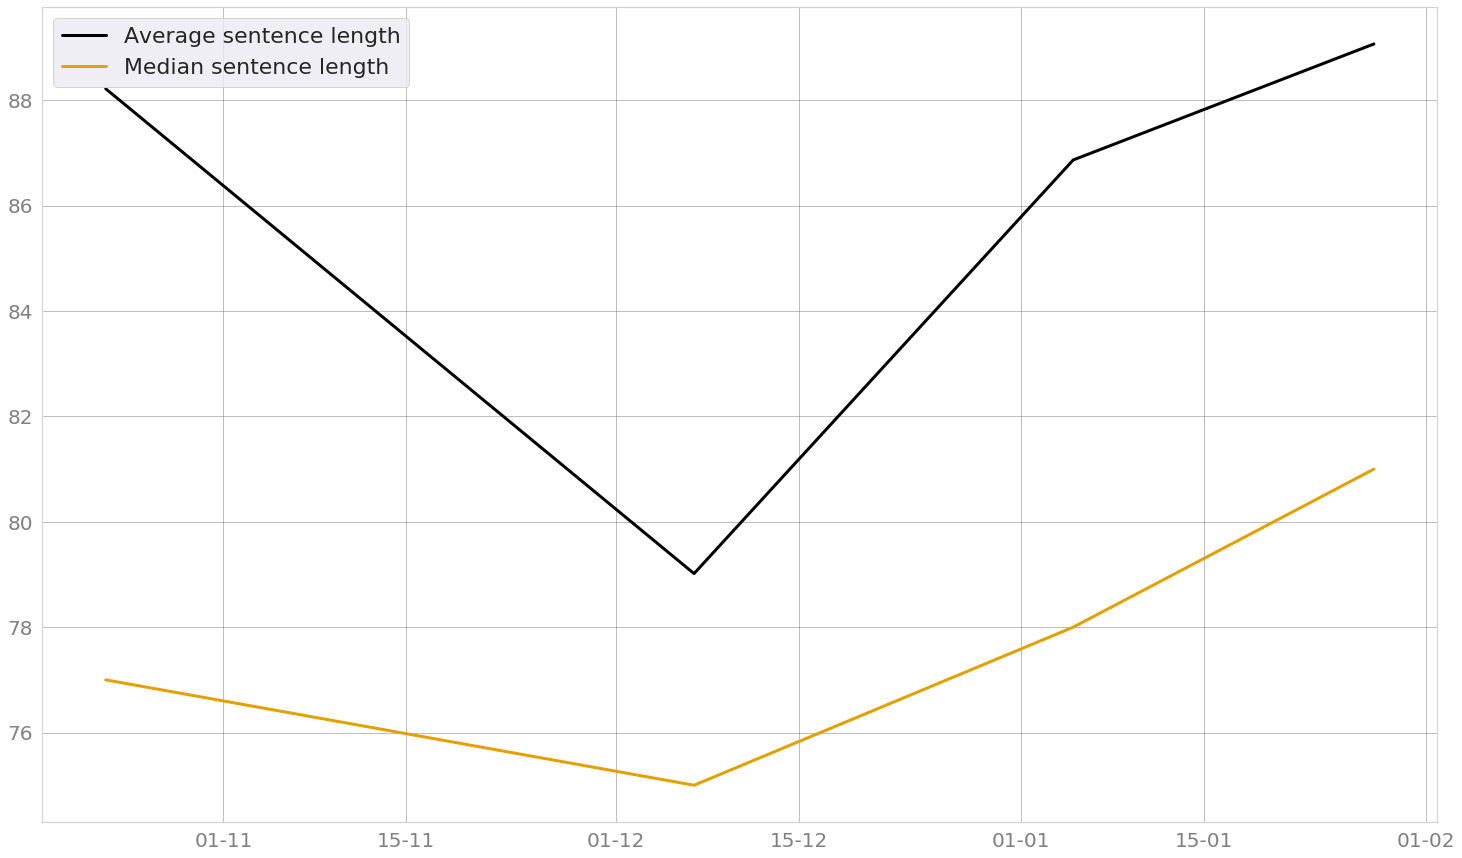

In [52]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyplot_themes as themes
import datetime as dt

matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

#nr_colors = len(freq_df["date"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)
#ax1 = sns.lineplot(x="index", y="Text_len", 
#                   label = "Text length",
#                  palette = palette[0], 
#                     linewidth = 3, data = df)

ax1 = sns.lineplot(x="index", y="Avg sentence len", 
                   label = "Average sentence length",
                  palette = palette[0], 
                     linewidth = 3, data = df)

ax1 = sns.lineplot(x="index", y="Median sentence len", 
                   label = "Median sentence length",
                  palette = palette[0], 
                     linewidth = 3, data = df)
#ax1 = sns.regplot(
#    data=freq_df,
#    x='date_ordinal',
#    y='nr_of_tweets',
#    color = palette[3],
#    ci=False
#    #y_jitter=.5
#)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")


# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

#ax1.set(ylim=(0, None))
#fig.suptitle("Mentions of 'vaccin*': Jan 2020 - Jan 2021", size = "40")
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()

plot_name = "fig/press_sentence_len.png"
fig.savefig(plot_name)

fig.show()

## Overall texts

In [53]:
import spacy
import string
from string import digits
import nltk

sp = spacy.load('da_core_news_lg')

file = open("../hope-b117/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

In [54]:
def lemmas(row):
    tweet = row["Texts"].lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #tweet = tweet.translate(str.maketrans('', '', digits))
    tweet = tweet.replace('”', '')
    tweet = tweet.replace('“', '')
    tweet = tweet.replace('»', '')
    tweet = tweet.replace('…','')
    
    sentence = sp(tweet)
    
    lemmas = []
    for word in sentence:
        lemmas.append(word.lemma_)
    
    res = [x for x in lemmas if x not in my_stop_words]
    hmm = ['    ','   ','  ',' ','', '🇩','🇰', '♂', '🤷', '–']
    res = [x for x in res if x not in hmm]
    return res

df["tokens_list"] = df.apply(lambda row: lemmas(row), axis = 1)

In [55]:
def join_tokens(row):
    res = " ".join(row["tokens_list"])
    return res

df["tokens_string"] = df.apply(lambda row: join_tokens(row), axis = 1)
texts = df["tokens_string"]

In [56]:
import string

texts = ", ".join(texts)
texts = texts.translate(str.maketrans('', '', string.punctuation))
texts = texts.lower()

In [57]:
word_freq = df.tokens_string.str.split(expand=True).stack().value_counts()
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

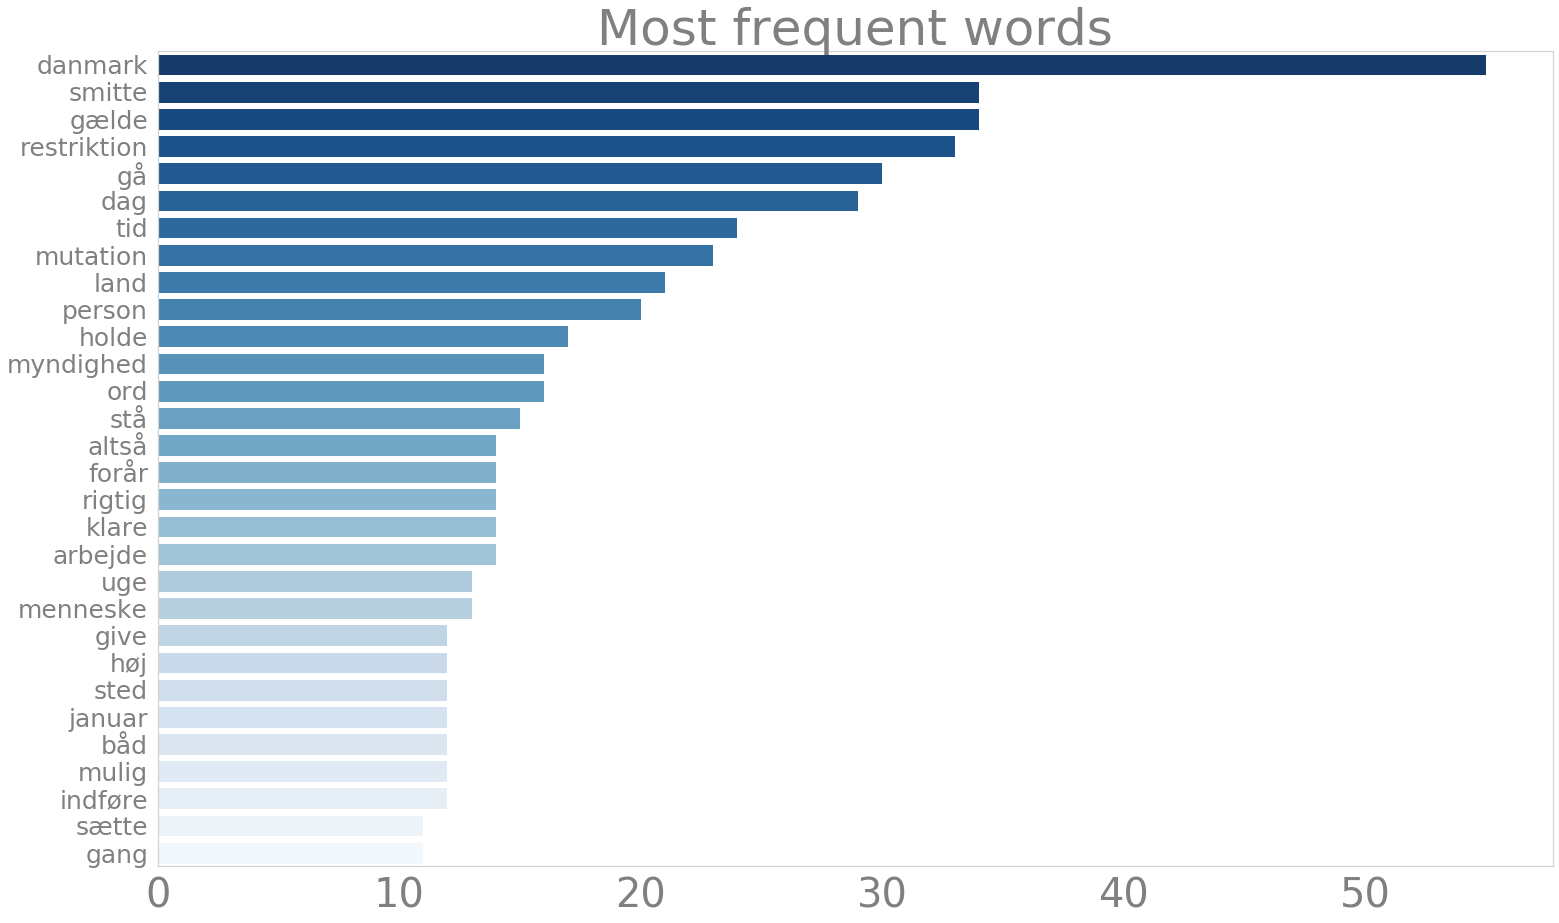

In [58]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

file = open("../hope-b117/stop_words.txt","r+")
stop_words = file.read().split()

word_freq = word_freq[~word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])
nr_hash = len(df0["word"].unique())

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
palette = sns.color_palette("Blues_r", nr_hash)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/press_word_frequency.png"
fig.savefig(plot_name)

In [33]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = "fig/press_word_cloud.png"
    plt.savefig(plot_name)

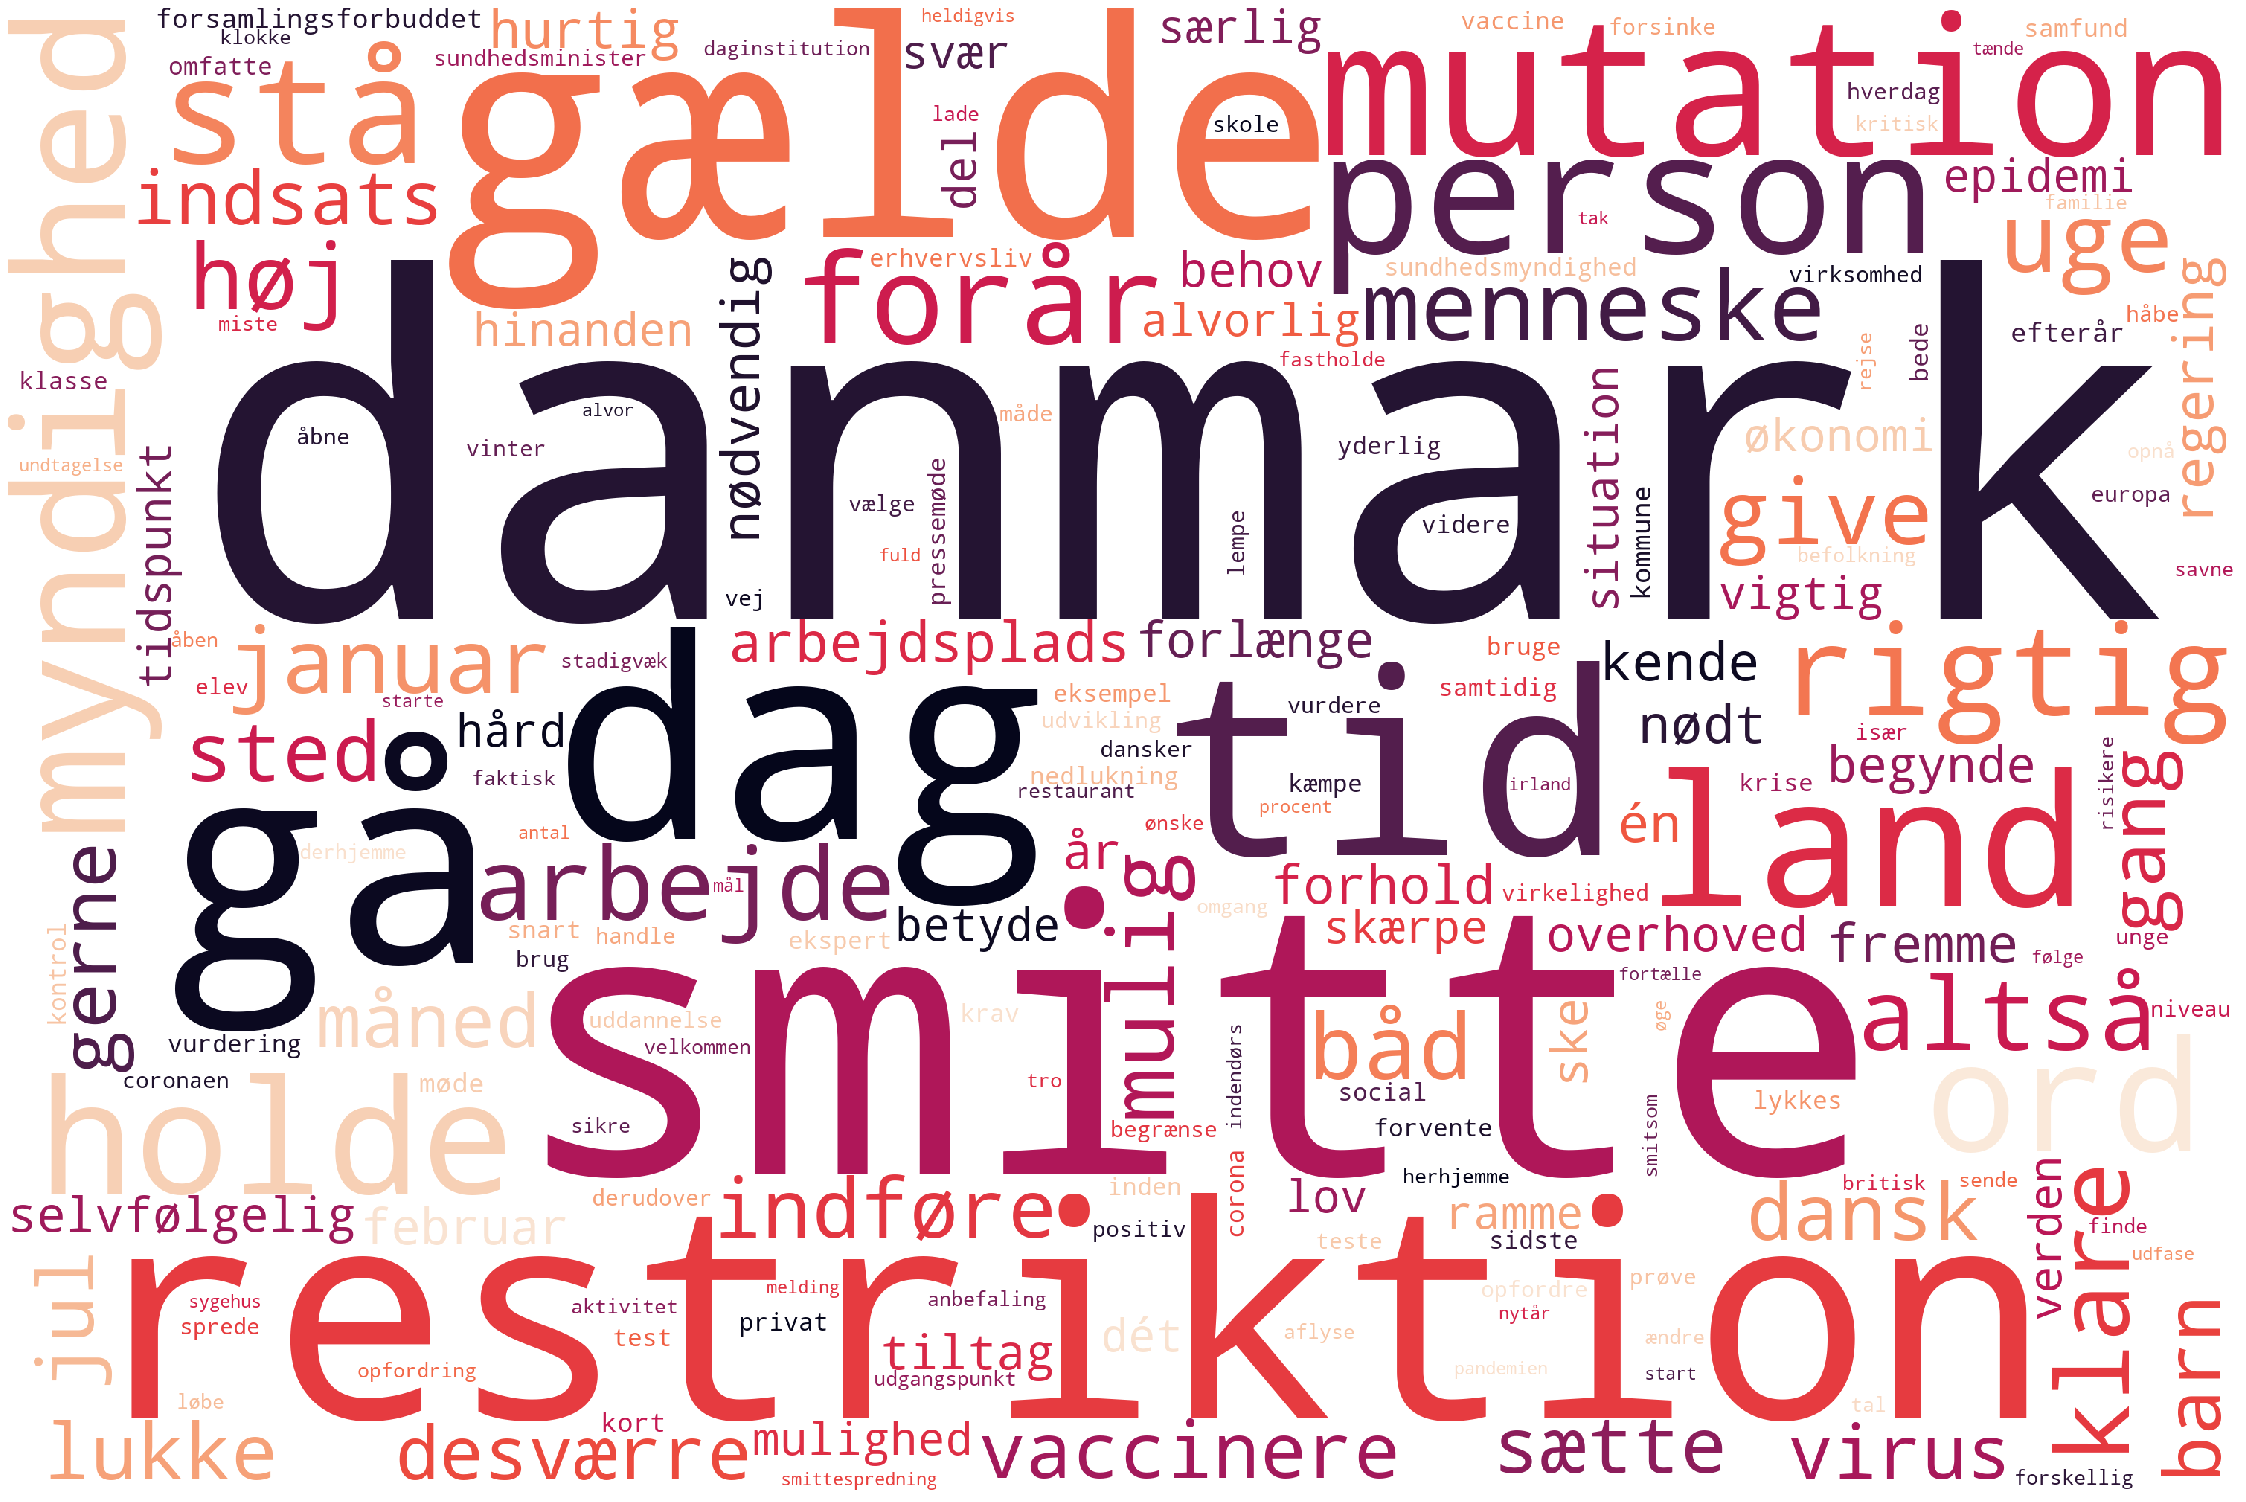

In [34]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = stop_words).generate(texts)
# Plot
plot_cloud(wordcloud)

In [35]:
from nltk import bigrams
import itertools
import collections
import networkx as nx
import spacy
import nltk

In [36]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#nlp = spacy.load("da_core_news_sm")

%matplotlib inline

In [37]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
#terms_bigram[0]

In [38]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

In [39]:
bigram_df.head(30)

bigram  count
0               (smitte, danmark)      7
1              (overhoved, mulig)      6
2                    (barn, unge)      5
3                   (ord, videre)      4
4                    (én, person)      4
5                    (holde, jul)      4
6               (pressemøde, dag)      3
7                  (danmark, uge)      3
8                   (28, februar)      3
9                    (04, klasse)      3
10               (ske, tidspunkt)      3
11         (restriktion, danmark)      3
12                  (sætte, gang)      3
13            (ekspert, anbefale)      3
14             (fysisk, fremmøde)      3
15                (danmark, land)      3
16                 (land, verden)      3
17          (dansk, arbejdsplads)      3
18                  (gerne, give)      3
19                    (give, ord)      3
20               (videre, omgang)      3
21     (omgang, sundhedsminister)      3
22  (sænke, forsamlingsforbuddet)      3
23                   (17, januar)      3
24            (bryde, smittekæde)      3
25              (januar, februar)      3
26   (landsdækkende, restriktion)      3
27              (efterår, vinter)      3
28                  (smitte, høj)      3
29              (kontrol, smitte)      3

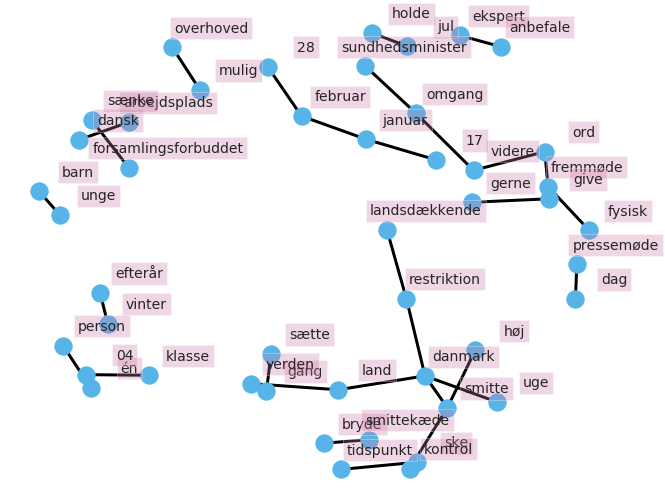

In [40]:
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color= palette[0], #'red',
                 node_color= palette[2], #'green',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

plt.savefig("fig/press_bigram_graph.png", dpi=150)

plt.show()

In [59]:
df

index                                              Texts  Text_len  \
0 2021-01-28  Velkommen til. Med pressemødet i dag vil vi gø...     11928   
1 2021-01-05  Velkommen til. Kun 5 dage inde i det nye år, s...     10040   
2 2020-12-07  Velkommen til pressemøde her i Statsministerie...      9477   
3 2020-10-23  Kære alle sammen – velkommen her til Statsmini...     10734   

   Avg sentence len  Median sentence len  \
0         89.068702                   81   
1         86.867257                   78   
2         79.017094                   75   
3         88.218487                   77   

                                         tokens_list  \
0  [velkommen, pressemøde, dag, status, epidemi, ...   
1  [velkommen, 5, dag, inde, år, stå, desværre, f...   
2  [velkommen, pressemøde, statsministerium, smit...   
3  [kære, velkommen, statsministerium, fredag, af...   

                                       tokens_string  
0  velkommen pressemøde dag status epidemi fortæl...  
1  velkommen 5 dag inde år stå desværre forurolig...  
2  velkommen pressemøde statsministerium smittetr...  
3  kære velkommen statsministerium fredag aften t...

## Frequent words per text

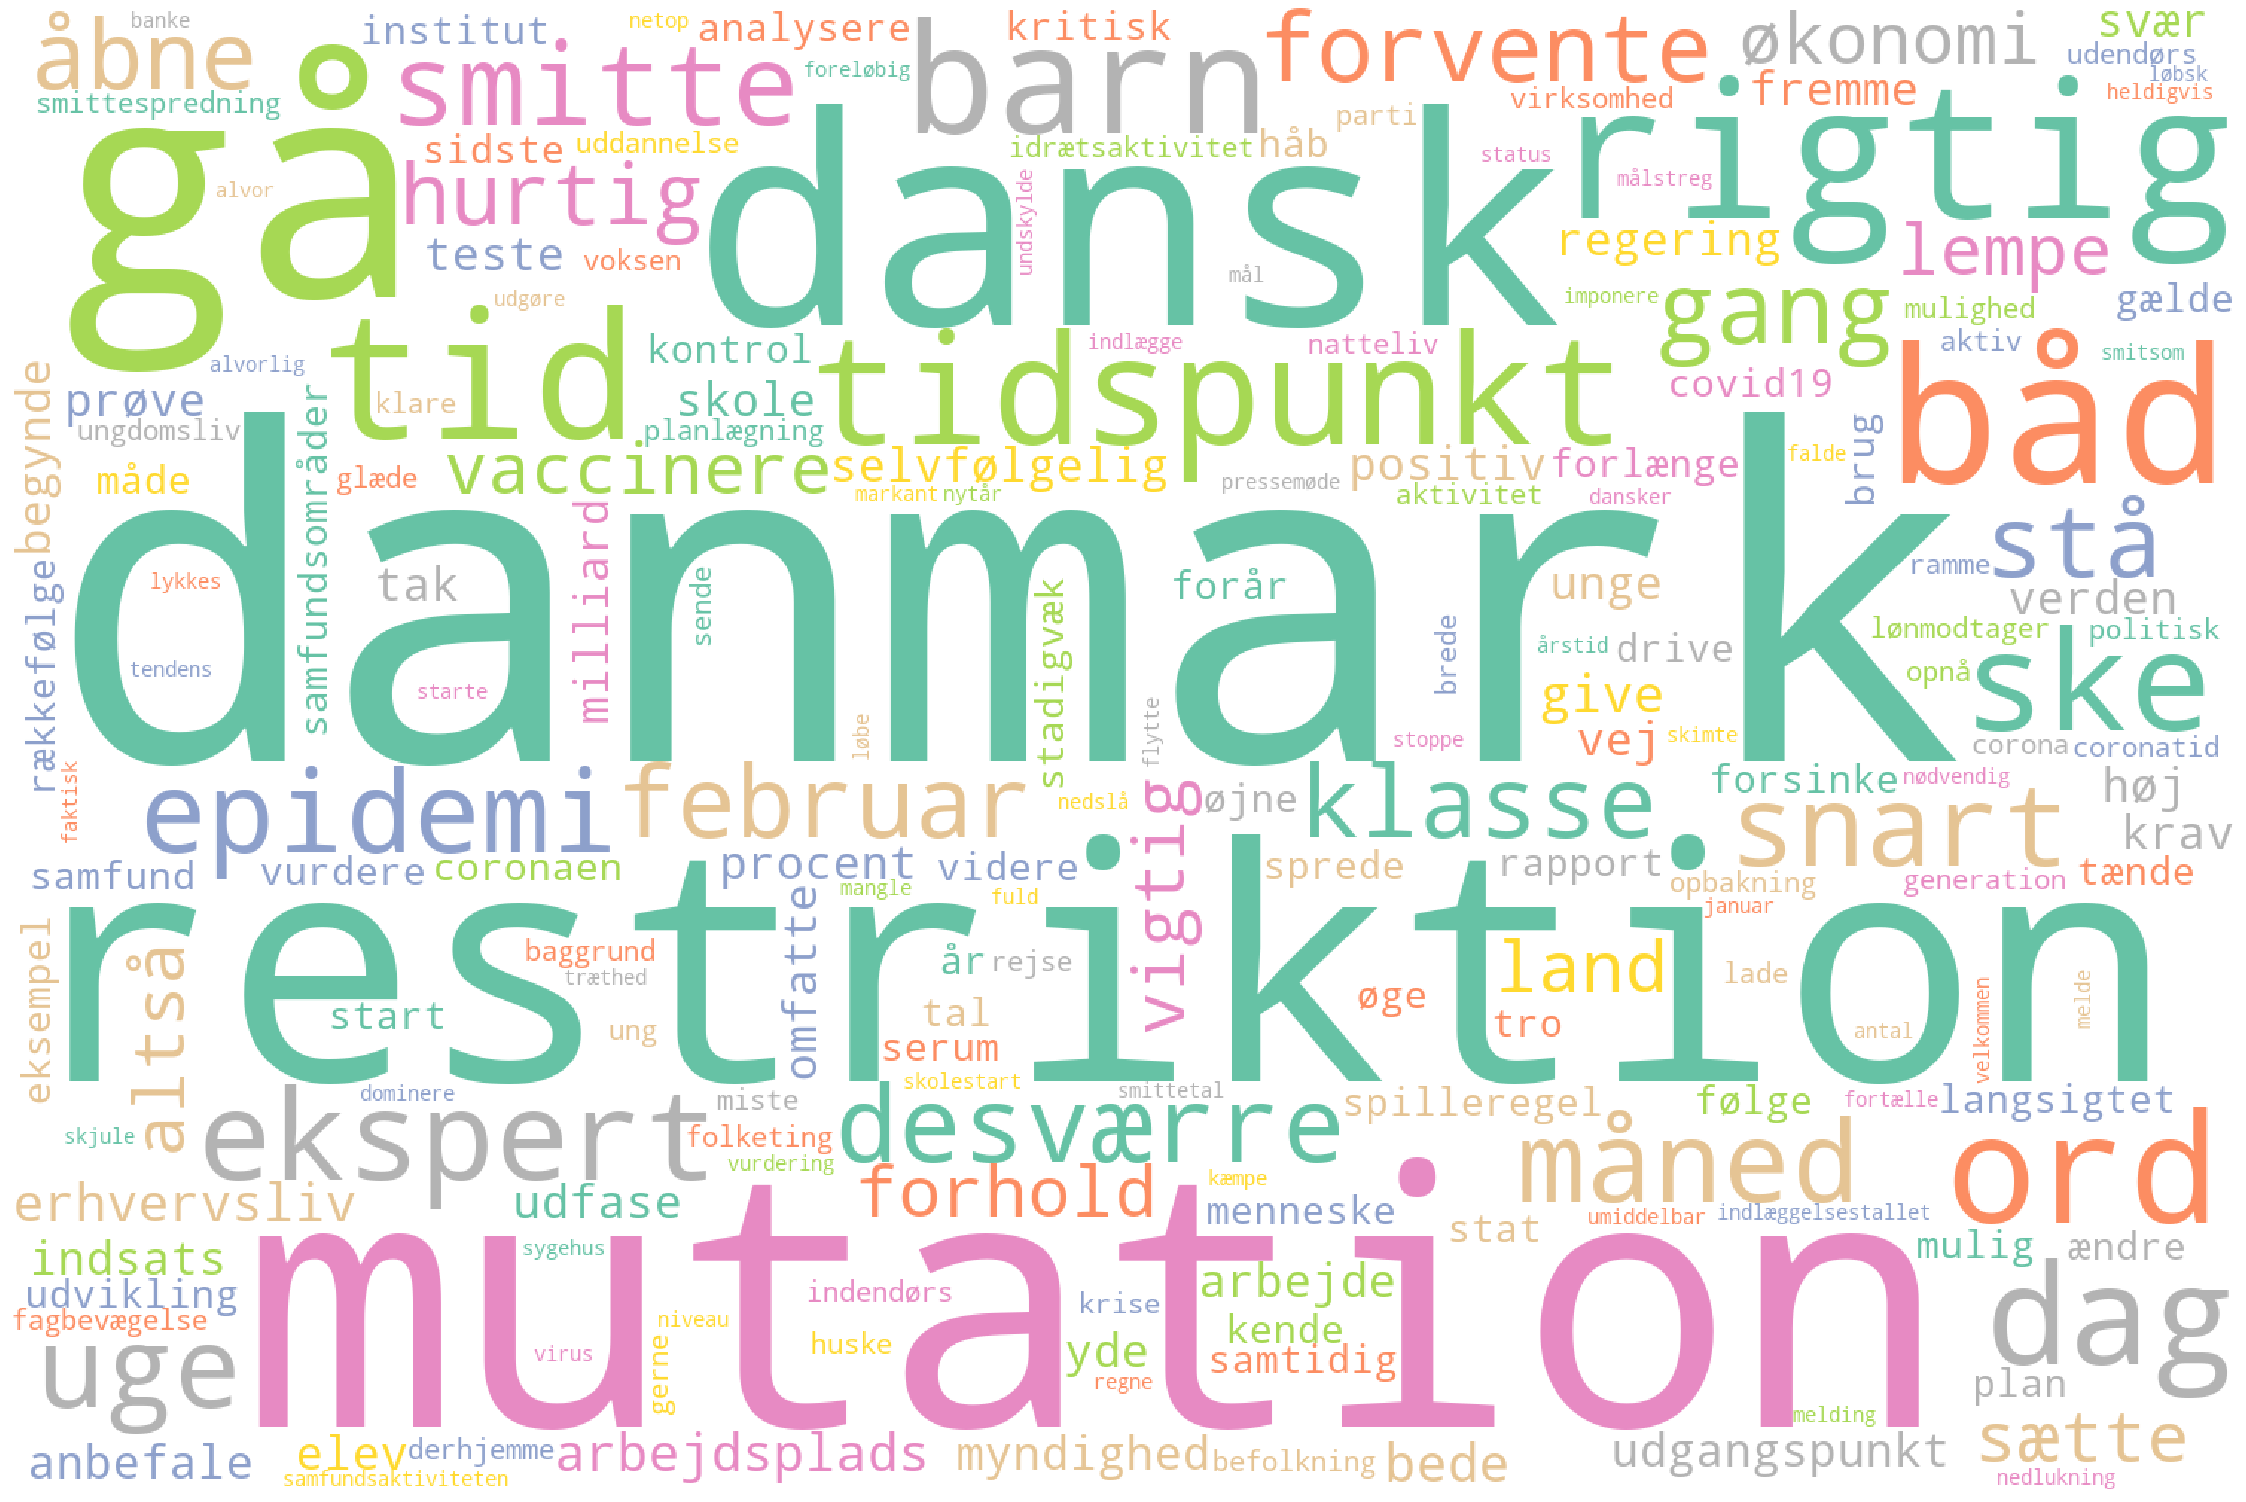

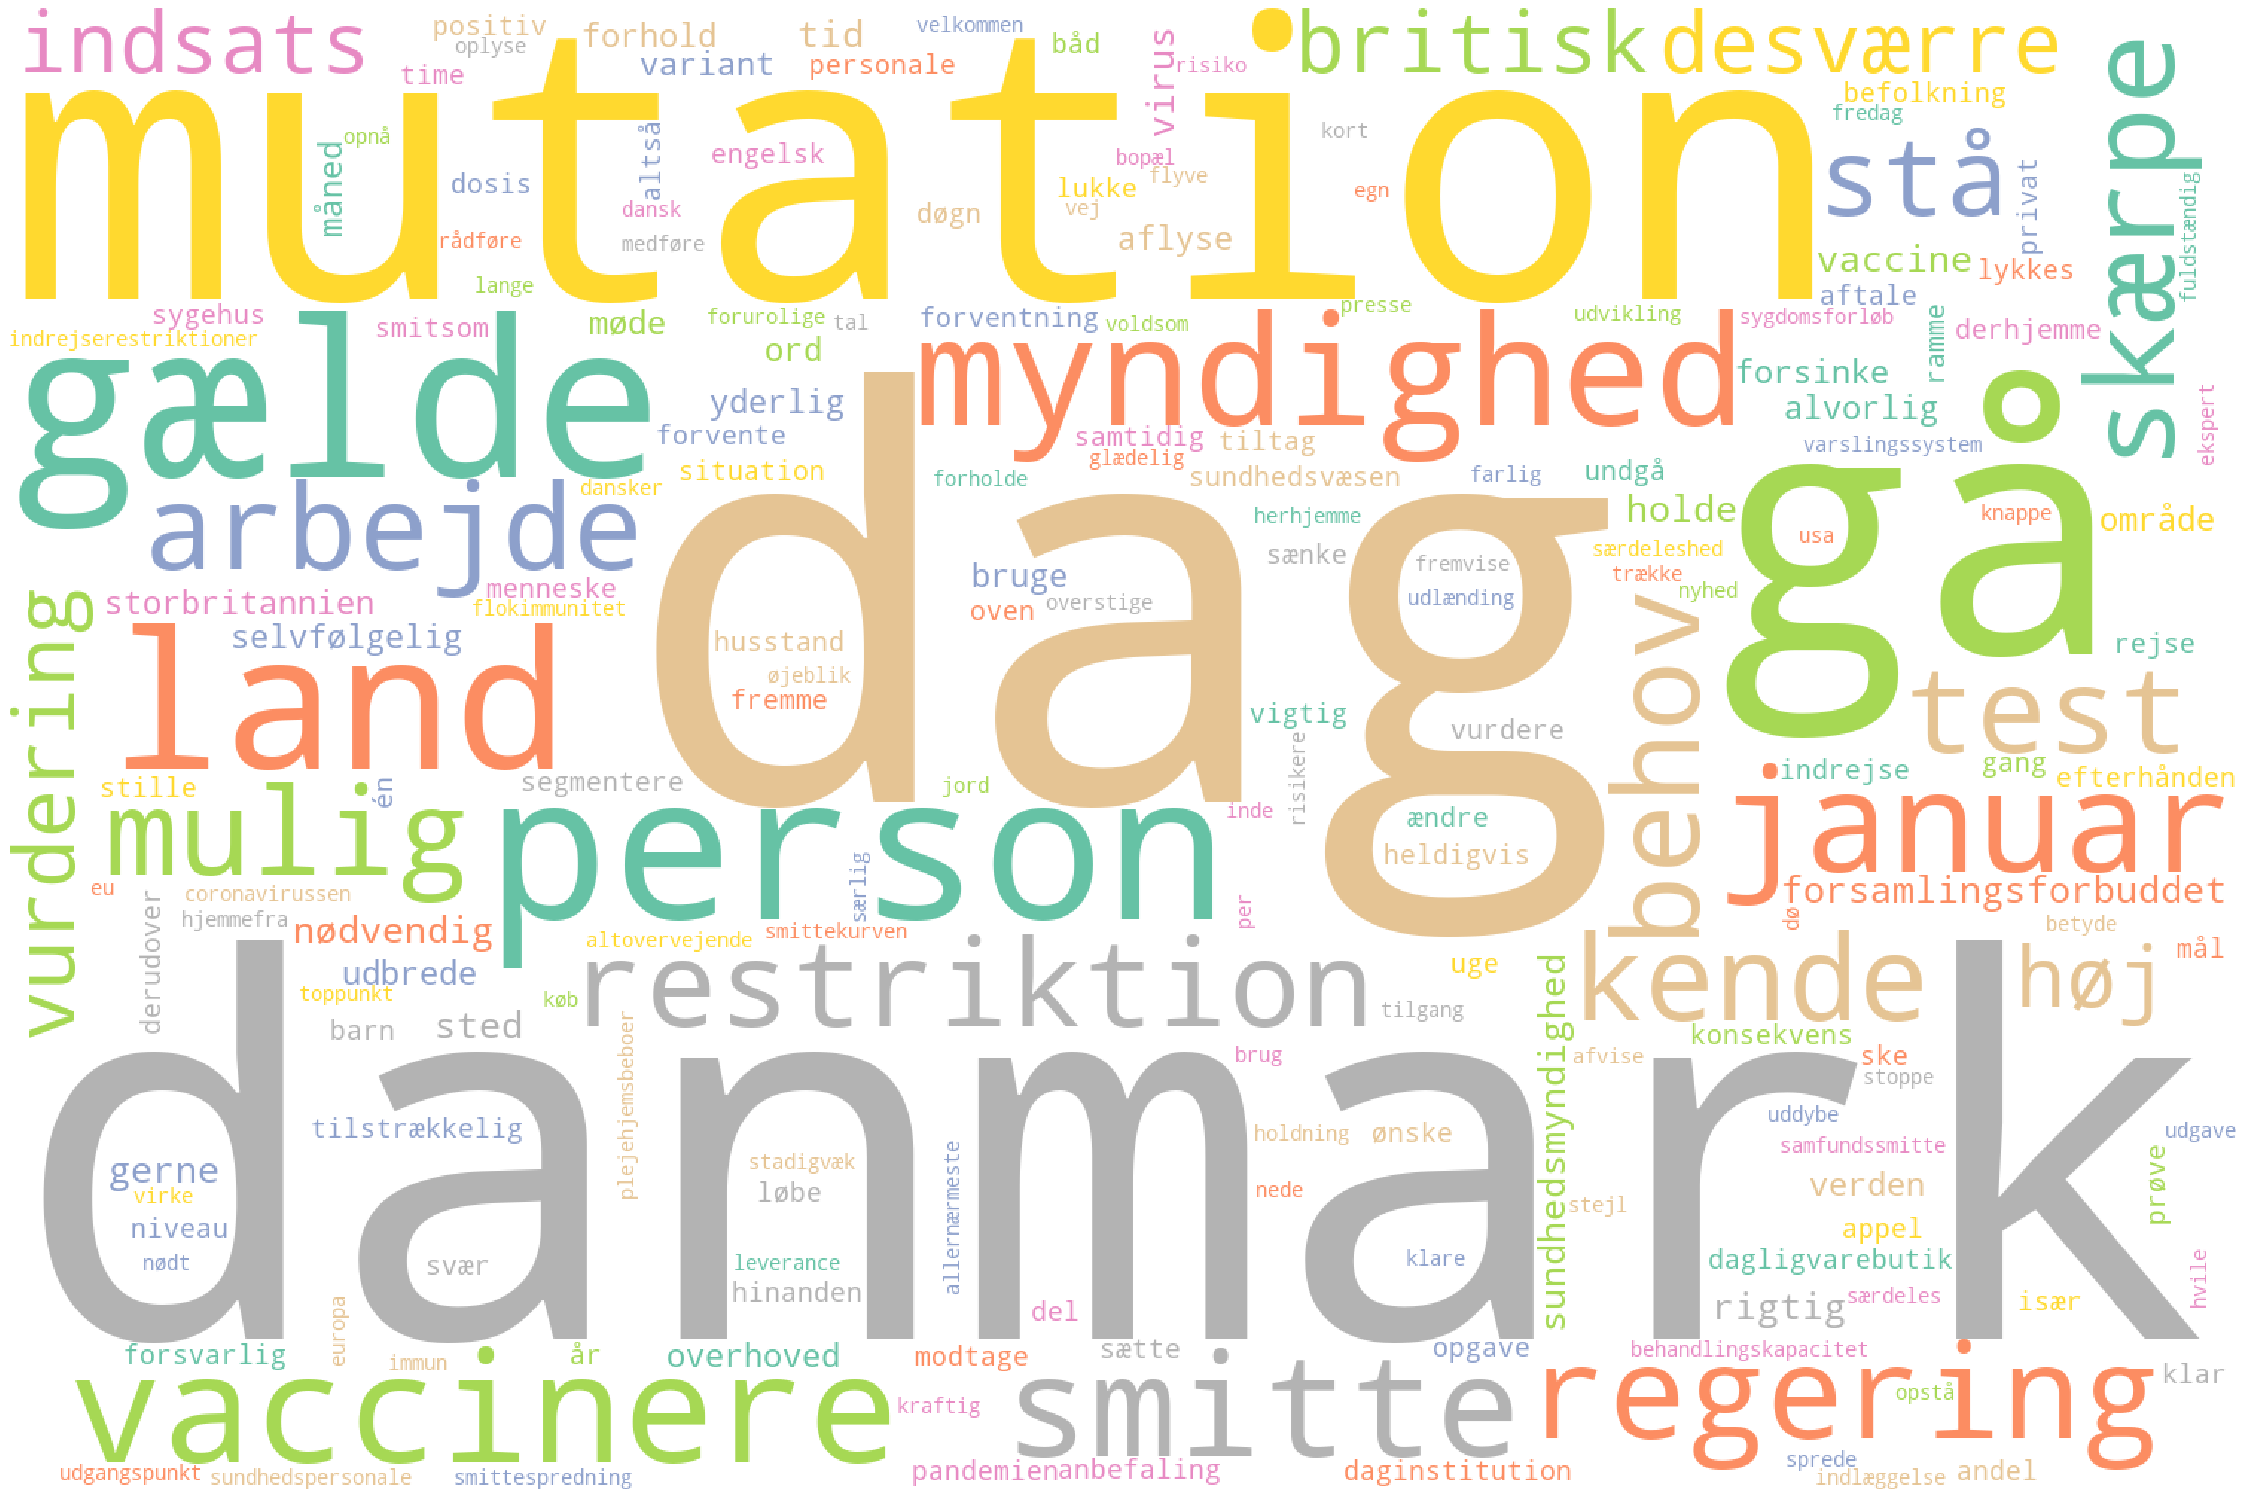

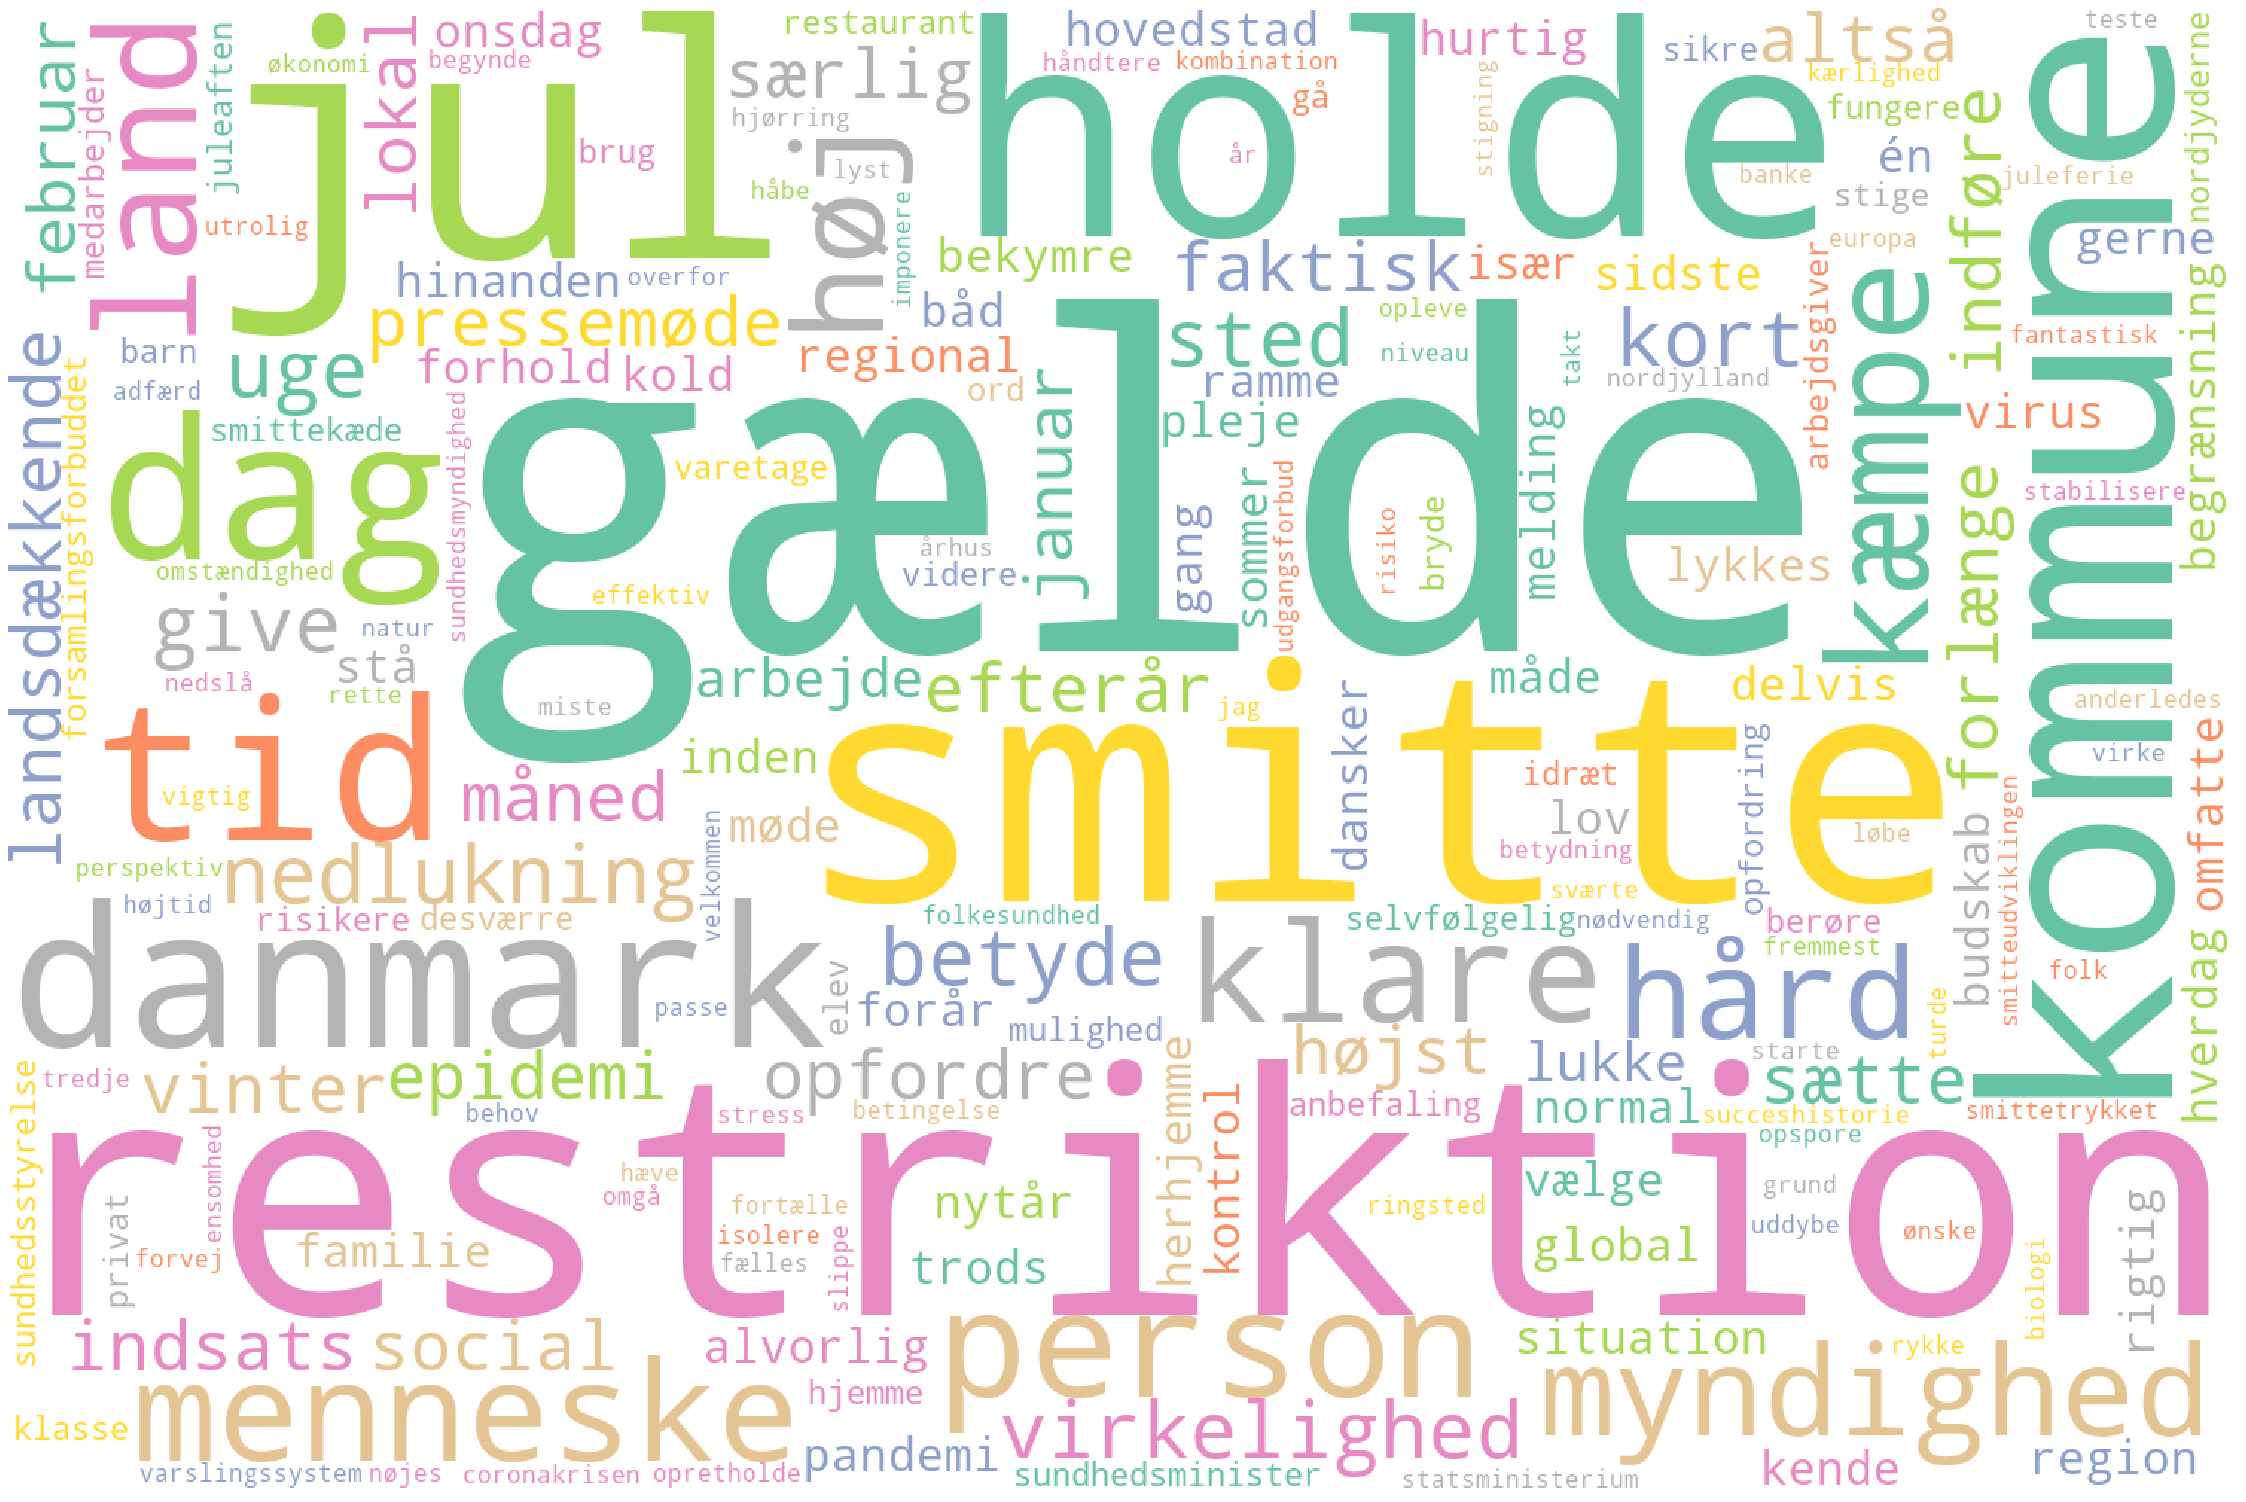

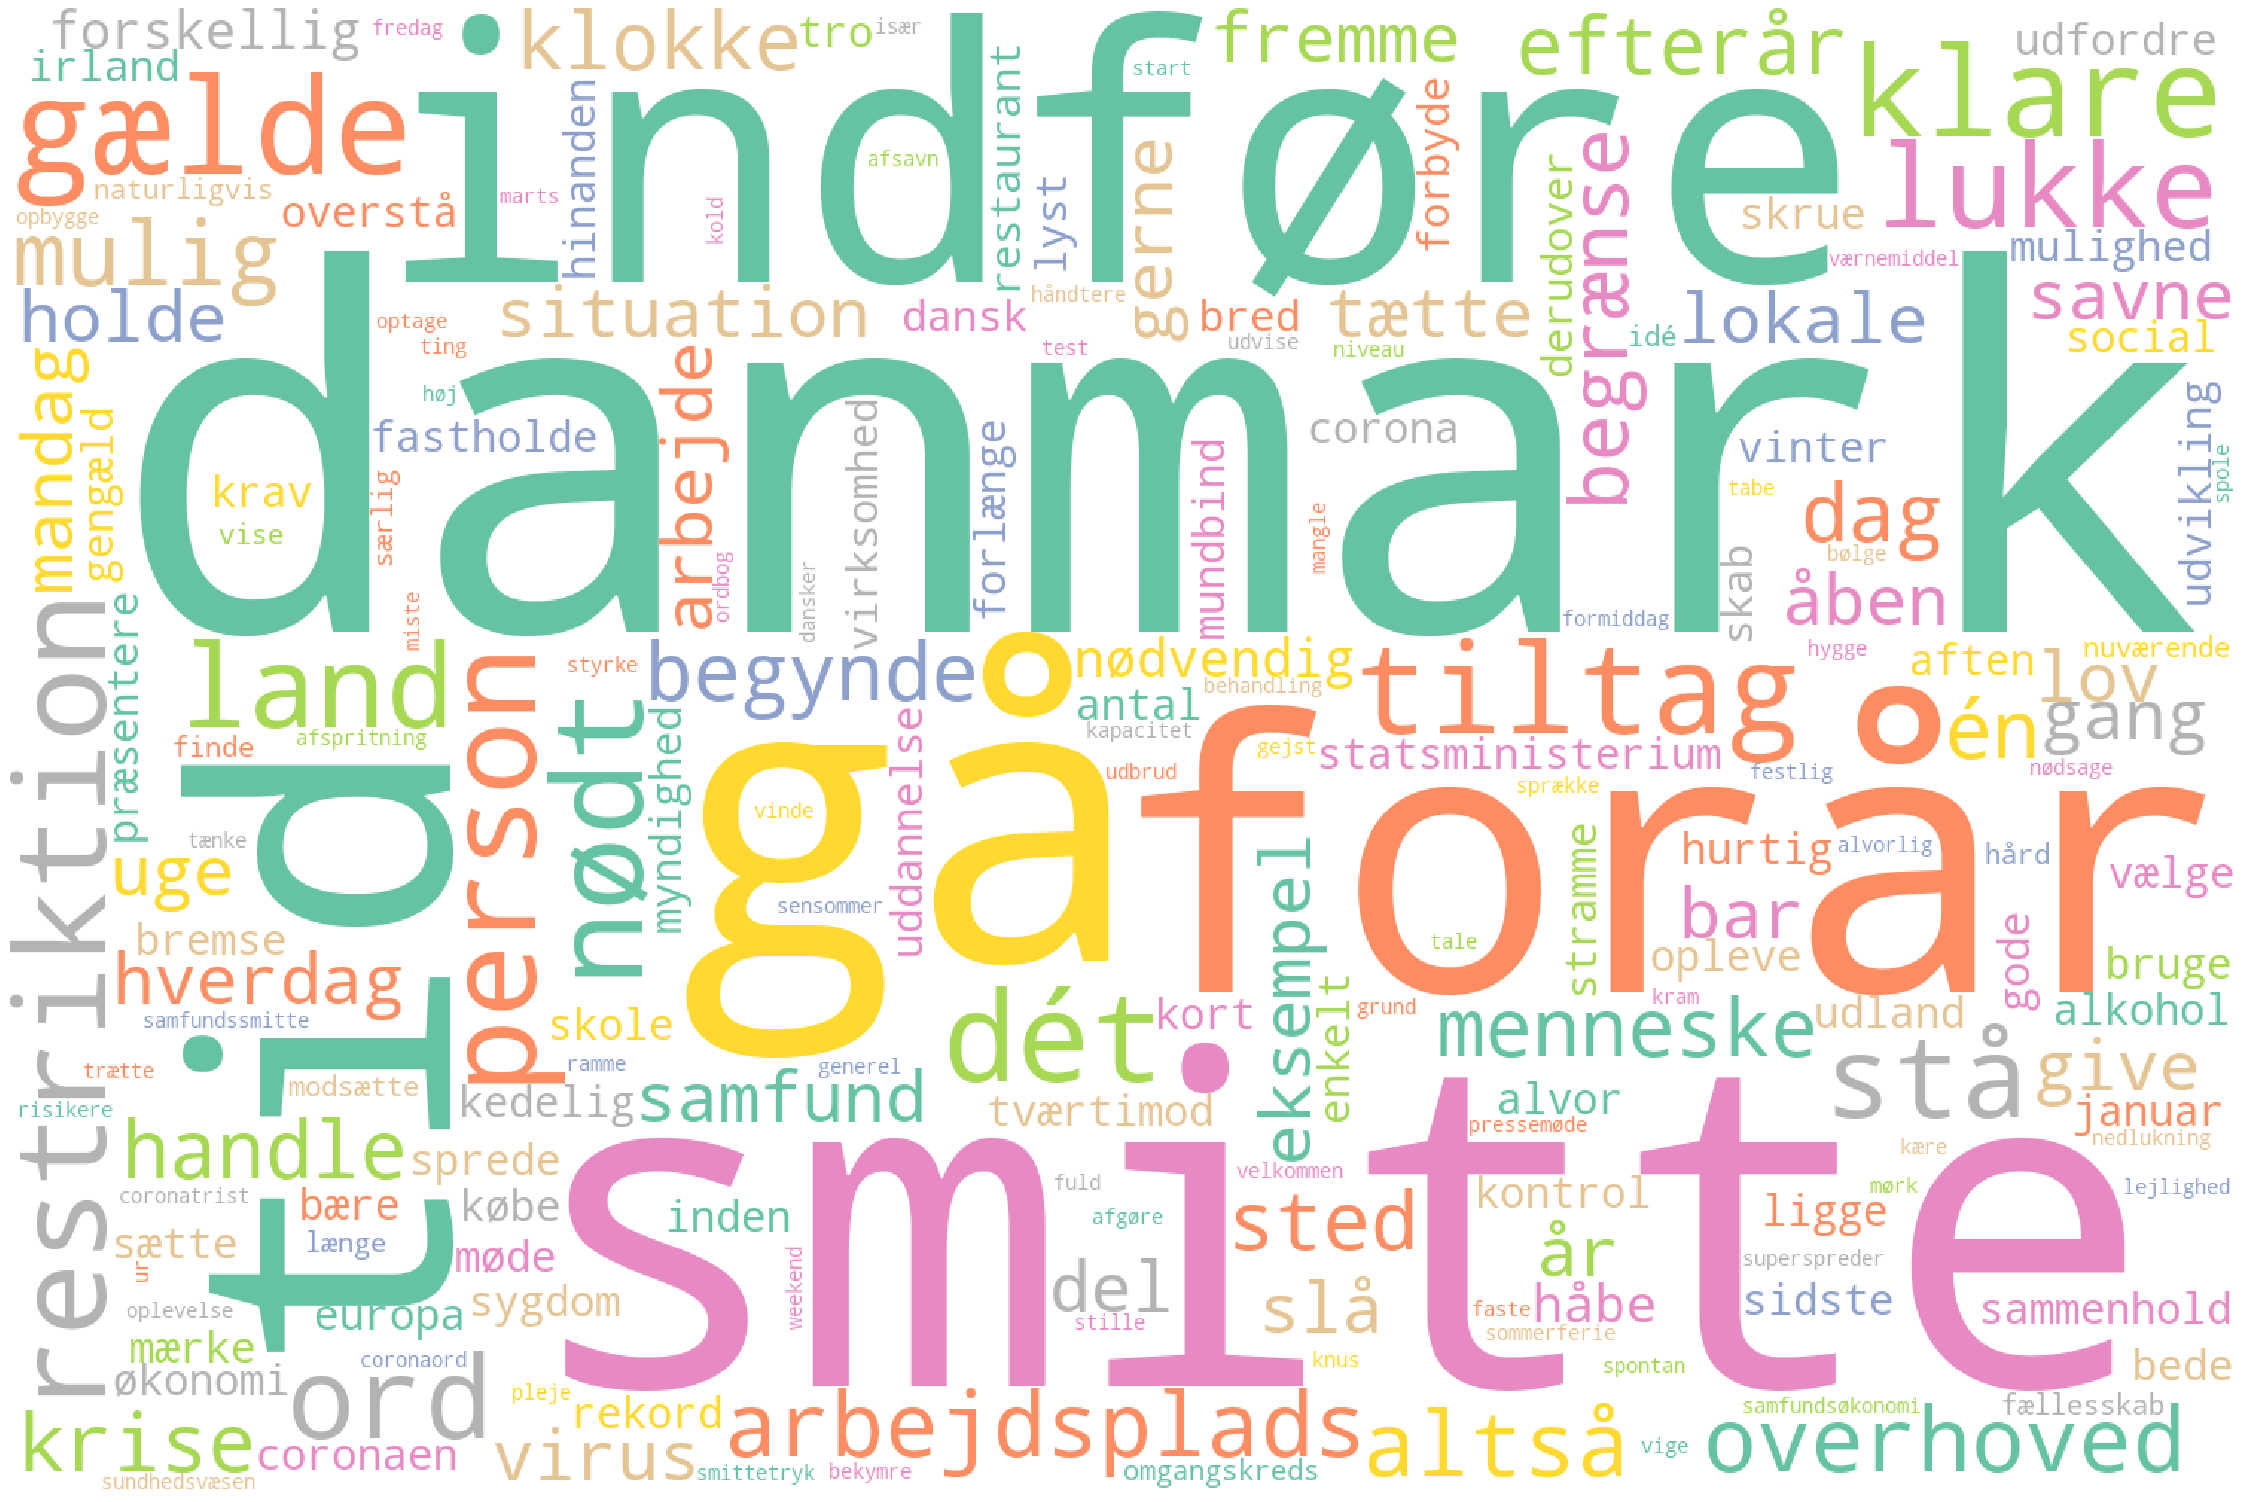

In [64]:
def plot_cloud(wordcloud, name):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = "fig/press_word_cloud_" + str(name) + ".png"
    plt.savefig(plot_name)

names = df.index.to_list()
i = 0
for row in df["tokens_string"]:
    texts = row
    texts = texts.translate(str.maketrans('', '', string.punctuation))
    texts = texts.lower()
    wordcloud = WordCloud(width = 1500, height = 1000, random_state=1, 
                      background_color='white', colormap="Set2", 
                      collocations=False, stopwords = stop_words).generate(texts)
    plot_cloud(wordcloud, names[i])
    i += 1

In [68]:
from collections import Counter

# dataframe of word counts per row
res = df['tokens_string'].str.split().apply(pd.value_counts)

In [69]:
res

danmark  mutation  restriktion    gå  dansk  båd  rigtig  tid  ord  barn  \
0     22.0      12.0         10.0   9.0    8.0  7.0     7.0  6.0  6.0   6.0   
1     12.0      11.0          5.0   9.0    1.0  2.0     4.0  4.0  3.0   2.0   
2      6.0       NaN         12.0   2.0    NaN  2.0     2.0  6.0  2.0   2.0   
3     15.0       NaN          6.0  10.0    2.0  1.0     1.0  8.0  5.0   1.0   

   ...   33  værnemiddel  topmøde  foreningsliv  detaljere  mørk  kram  \
0  ...  NaN          NaN      NaN           NaN        NaN   NaN   NaN   
1  ...  NaN          NaN      NaN           NaN        NaN   NaN   NaN   
2  ...  NaN          NaN      NaN           NaN        NaN   NaN   NaN   
3  ...  1.0          1.0      1.0           1.0        1.0   1.0   1.0   

   behandling  bekymring  superspreder  
0         NaN        NaN           NaN  
1         NaN        NaN           NaN  
2         NaN        NaN           NaN  
3         1.0        1.0           1.0  

[4 rows x 996 columns]

In [71]:
res_words = res.T.reset_index().rename(columns={"index": "word", 0:"Text0", 1:"Text1", 2:"Text2", 3: "Text3"})
word_freq = res_words[~res_words["word"].isin(stop_words)]
word_freq

word  Text0  Text1  Text2  Text3
0         danmark   22.0   12.0    6.0   15.0
1        mutation   12.0   11.0    NaN    NaN
2     restriktion   10.0    5.0   12.0    6.0
3              gå    9.0    9.0    2.0   10.0
4           dansk    8.0    1.0    NaN    2.0
..            ...    ...    ...    ...    ...
991          mørk    NaN    NaN    NaN    1.0
992          kram    NaN    NaN    NaN    1.0
993    behandling    NaN    NaN    NaN    1.0
994     bekymring    NaN    NaN    NaN    1.0
995  superspreder    NaN    NaN    NaN    1.0

[993 rows x 5 columns]

In [72]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

text_nr = "Text0"

def visualise_freq_word_per_text(text_nr, name):
    df0 = word_freq.nlargest(30, columns=[text_nr])
    nr_hash = len(df0["word"].unique())

    matplotlib.rc('ytick', labelsize=30)
    matplotlib.rc('xtick', labelsize=30)

    themes.theme_minimal(grid=False, ticks=False, fontsize=18)
    a4_dims = (25,15) #(11.7, 8.27)

    fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

    themes.theme_minimal(grid=False, ticks=False, fontsize=18)
    palette = sns.color_palette("Blues_r", nr_hash)

    ax = sns.barplot(y="word", x=text_nr, palette = palette, data = df0)

    ax.set(xlabel="Count", ylabel = "Hashtag")
    ax.xaxis.get_label().set_fontsize(25)
    ax.yaxis.get_label().set_fontsize(25)
    ax.axes.set_title("Most frequent words",fontsize=50)

    plt.xticks(fontsize=40)
    plt.yticks(fontsize=25)

    ax.set(xlabel="", ylabel = "")
    ax.xaxis.get_label().set_fontsize(100)
    ax.yaxis.get_label().set_fontsize(40)

    plot_name = "fig/press_word_frequency_" + str(name) + ".png"
    #fig.savefig(plot_name)
    fig.show()

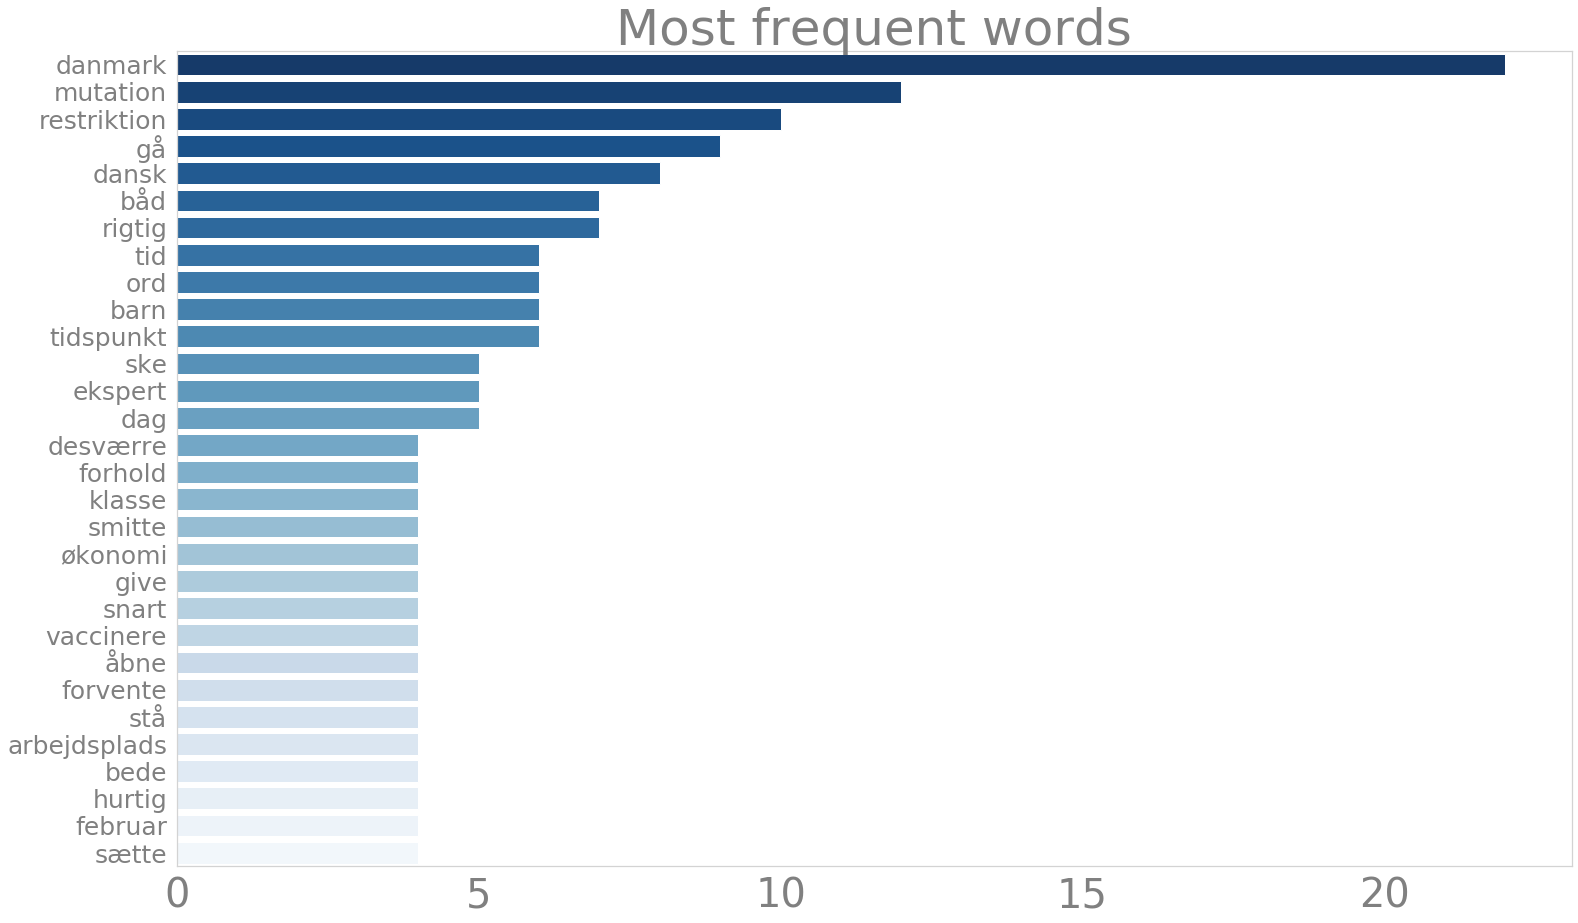

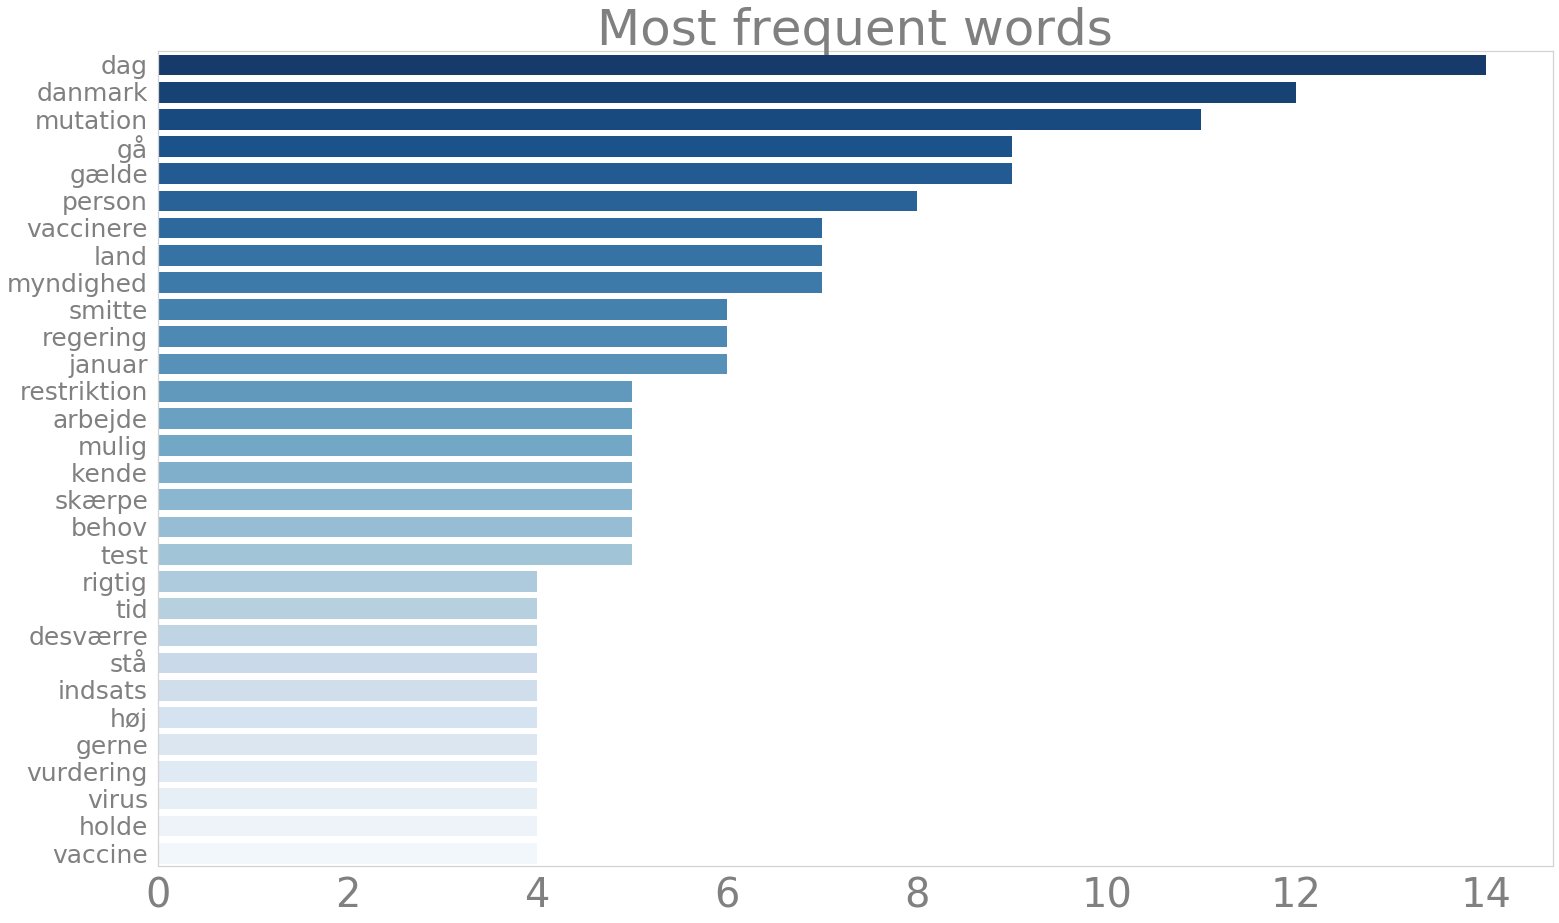

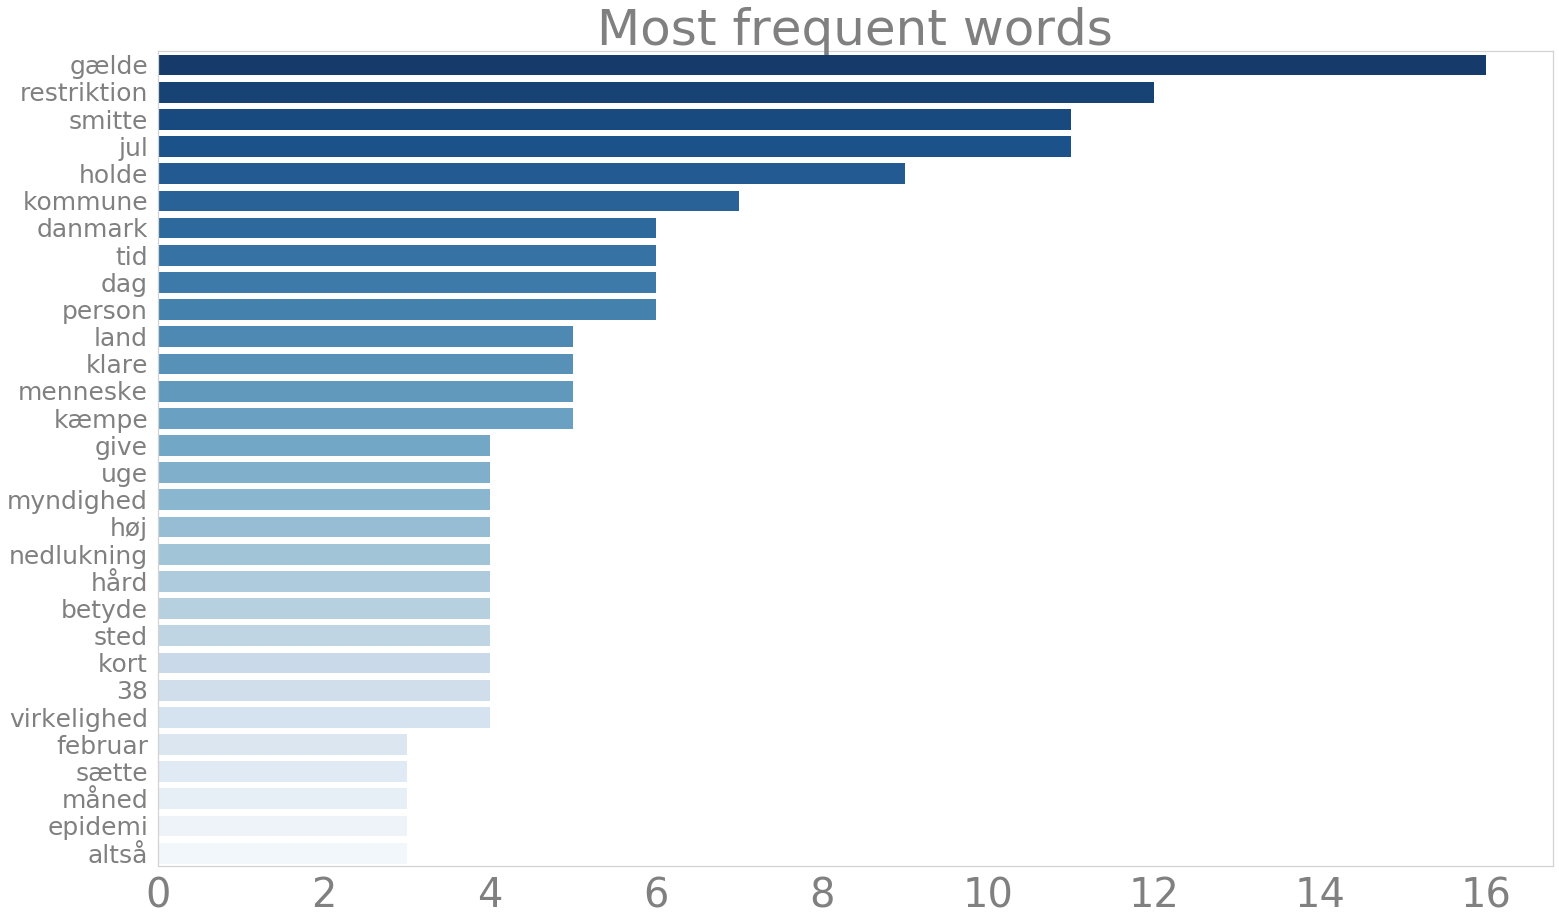

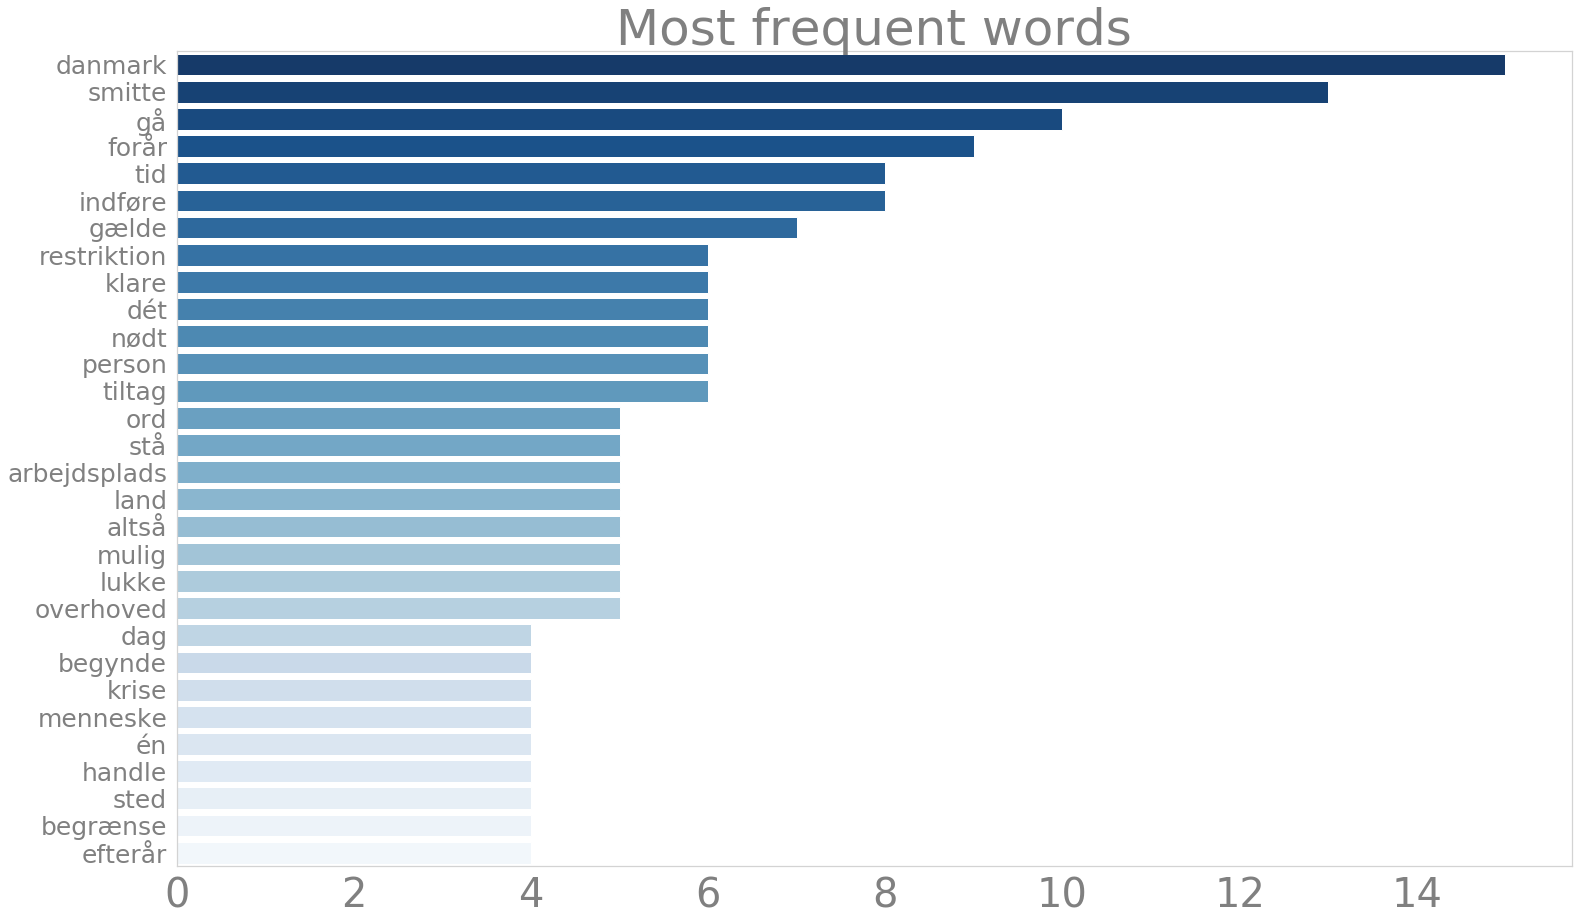

In [73]:
visualise_freq_word_per_text("Text0", 0)
visualise_freq_word_per_text("Text1", 1)
visualise_freq_word_per_text("Text2", 2)
visualise_freq_word_per_text("Text3", 3)